*Technical University of Munich<br>
Professorship of Environmental Sensing and Modeling<br><br>*
**Author:**  Daniel Kühbacher<br>
**Date:**  07.10.2024

--- 

# Uncertainty of the single detector emission estimate

<!--Notebook description and usage information-->


In [3]:
import sys
import os
os.environ['USE_PYGEOS'] = '0'

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import scipy.stats as stats
import math

from datetime import time

sys.path.append('../../utils')
import data_paths
from hbefa_hot_emissions import HbefaHotEmissions
from hot_emission_process import process_hourly_emissions
from traffic_counts import TrafficCounts

In [4]:
# initialize hbefa 
hbefa_obj = HbefaHotEmissions()
# initialize traffic cycles
cycles = TrafficCounts(init_timeprofile=False)
# import visum data
visum_links = gpd.read_file(data_paths.VISUM_FOLDER_PATH + 'visum_links.gpkg')

Loaded emission factors from /Users/daniel_tum/Documents/code/drive-inventory/data/restricted_input/hbefa/EFA_HOT_ts_hbefa.txt
Loaded emission factors from /Users/daniel_tum/Documents/code/drive-inventory/data/restricted_input/hbefa/EFA_HOT_aggregated_hbefa.txt


# Import detector-based emissions for comparison

In [11]:
# import detector emission data
_fname = data_paths.INVENTORY_PATH + 'DetectorEmissions_2019_vc_estimate.feather'
#_fname = data_paths.INVENTORY_FOLDER_PATH + 'DetectorEmissions_2019.feather'
df = pd.read_feather(_fname)

# Use Inventory Model to calculate the Emission

In [12]:
road_links_with_detectors = df['road_link_id'].unique()
visum_reduced = visum_links[visum_links['road_link_id']\
    .isin(road_links_with_detectors)].copy()
visum_reduced = visum_reduced.reset_index(drop=True).reset_index()

In [13]:
final_emissions = list()

for day in pd.date_range(start='2019-01-01', end= '2019-12-31', freq = 'd'): # for all days in 2019
    
    em_dict = process_hourly_emissions(day.strftime('%Y-%m-%d'),
                                        visum_reduced.to_dict('records'),
                                        cycles,
                                        hbefa_obj)
    
    df_temp = pd.DataFrame()
    for road_link_index, item in em_dict.items():
        
        data = pd.DataFrame(pd.Series(item).reset_index())
        data.rename(columns = {'level_0':'vehicle_class',
                               'level_1':'component',
                               'level_2':'hour',
                               0:'emission'},
                    inplace = True)
        data['date'] = day
        data['road_link_index'] = road_link_index
        df_temp = pd.concat([df_temp, data], axis = 0)
    final_emissions.append(df_temp)
model_dat = pd.concat(final_emissions)
model_dat['road_link_id'] = model_dat['road_link_index'].map(visum_reduced['road_link_id'].to_dict())
model_dat['timestamp'] = model_dat.apply(lambda row: pd.Timestamp.combine(row['date'],
                                                                          time(row['hour'])), axis = 1)

In [14]:
# serialize table
model_dat_long = model_dat.groupby(['vehicle_class',
                             'timestamp',
                             'road_link_id',
                             'component'])['emission'].sum().reset_index()

model_dat_long = model_dat_long.pivot(index = ['road_link_id', 'timestamp'],
                                      columns=['component', 'vehicle_class'],
                                      values = 'emission')

model_dat_long.head()

component                                CO      CO2(rep)        NOx  \
vehicle_class                           HGV           HGV        HGV   
road_link_id timestamp                                                 
38           2019-01-01 00:00:00  24.916415  12224.739047  65.226099   
             2019-01-01 01:00:00  31.145519  15280.923809  81.532624   
             2019-01-01 02:00:00  24.916415  12224.739047  65.226099   
             2019-01-01 03:00:00  24.916415  12224.739047  65.226099   
             2019-01-01 04:00:00  24.916415  12224.739047  65.226099   

component                                CO      CO2(rep)        NOx  \
vehicle_class                           LCV           LCV        LCV   
road_link_id timestamp                                                 
38           2019-01-01 00:00:00  35.499485  21790.042968  90.431766   
             2019-01-01 01:00:00  29.582904  18158.369140  75.359805   
             2019-01-01 02:00:00  25.638517  15737.253254  65.311831   
             2019-01-01 03:00:00  19.721936  12105.579426  50.239870   
             2019-01-01 04:00:00  19.721936  12105.579426  50.239870   

component                                 CO      CO2(rep)         NOx  
vehicle_class                             PC            PC          PC  
road_link_id timestamp                                                  
38           2019-01-01 00:00:00  406.621890  92573.713244  221.044372  
             2019-01-01 01:00:00  324.189173  73806.640201  176.232992  
             2019-01-01 02:00:00  214.047980  48731.307312  116.358963  
             2019-01-01 03:00:00  176.641537  40215.156520   96.024387  
             2019-01-01 04:00:00  157.938315  35957.081124   85.857099

# Prepare combined dataset

In [49]:
def process_trasit(trasit):
    return str(trasit).split('/')[-1]

In [68]:
combined = pd.DataFrame()
for component in ['CO2(rep)', 'NOx', 'CO']:
    
    model = model_dat_long[component].sum(axis =1)
    model.name = f'model_{component}'
    detector = df.groupby(['road_link_id',
                          'timestamp'])[[f'{x}_{component}' for x in hbefa_obj.vehicle_classes]].sum().sum(axis=1)
    detector.name = f'detector_{component}'
    
    combined = pd.concat([combined, model, detector], axis = 1)
    
_trasit = df.groupby(['road_link_id','timestamp'])['TraSit'].first()
trasit = _trasit.apply(process_trasit)
    
combined = pd.concat([combined, trasit], axis = 1)
combined = combined.dropna()

# Calculate hourly differences

In [53]:
def normal(ax, mean, std, color="black"):
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = stats.norm.pdf(x, mean, std)
    z = ax.plot(x, p, color, linewidth=2)

In [54]:
def lognormal(ax, s, loc, scale,  color="black"):
    x = np.linspace(-1, 1.5, 200)
    p = stats.lognorm.pdf(x, s, loc = loc, scale = scale)
    z = ax.plot(x, p, color, linewidth=2, linestyle='--')

<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:33: SyntaxWarning: invalid escape sequence '\s'
<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:33: SyntaxWarning: invalid escape sequence '\s'
<>:45: SyntaxWarning: invalid escape sequence '\s'
/var/folders/5v/yv2xq6j56r5459_qjzrm79rw0000gn/T/ipykernel_29771/12874272.py:22: SyntaxWarning: invalid escape sequence '\s'
  text = f'95% CI: [{lb*100:.1f}%, {ub*100:.1f}%] \n$\sigma$= {s*100:.1f}%'
/var/folders/5v/yv2xq6j56r5459_qjzrm79rw0000gn/T/ipykernel_29771/12874272.py:33: SyntaxWarning: invalid escape sequence '\s'
  text = f'95% CI: [{lb1*100:.1f}%, {ub1*100:.1f}%] \n$\sigma$= {s*100:.1f}%'
/var/folders/5v/yv2xq6j56r5459_qjzrm79rw0000gn/T/ipykernel_29771/12874272.py:45: SyntaxWarning: invalid escape sequence '\s'
  text = f'95% CI: [{lb2*100:.1f}%, {ub2*100:.1f}%] \n$\sigma$= {s*100:.1f}%'
/var/folders/5v/yv2xq6j56r5459_qjzrm79rw0000gn/T/ipykernel_29771/12874272.py:9: FutureW

0.3414493330114399 0 1
0.2785733372928241 0 1
0.28911122128574473 0 1


/var/folders/5v/yv2xq6j56r5459_qjzrm79rw0000gn/T/ipykernel_29771/12874272.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_a = df_h.reset_index(level = 0).groupby('level_0').resample('1Y').sum()


0.34350573906920623 0 1
0.28691188060311124 0 1
0.31022118937383175 0 1


/var/folders/5v/yv2xq6j56r5459_qjzrm79rw0000gn/T/ipykernel_29771/12874272.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_a = df_h.reset_index(level = 0).groupby('level_0').resample('1Y').sum()


0.3680862422522172 0 1
0.2798648188139719 0 1
0.2630087533651701 0 1


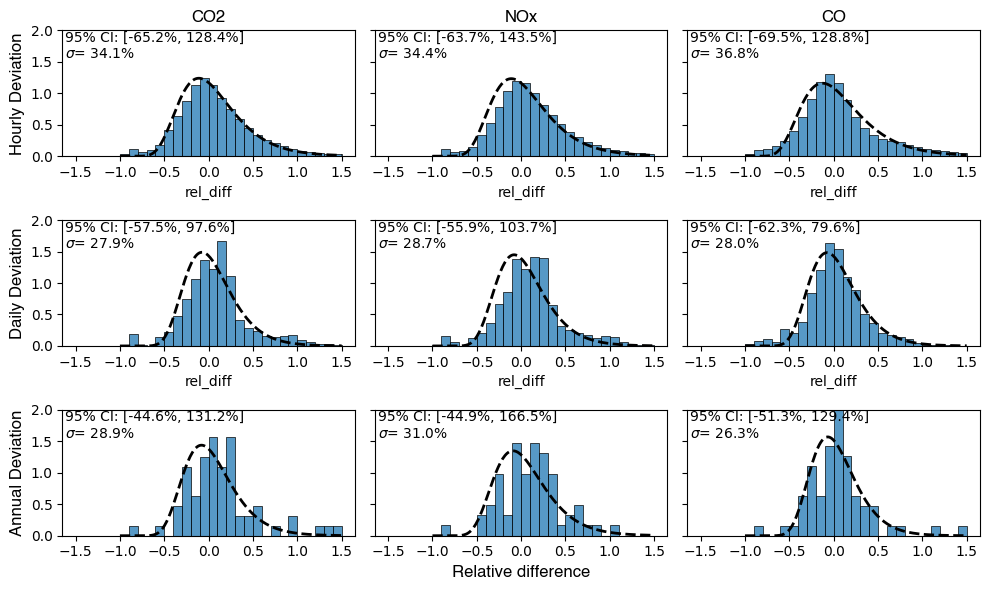

In [55]:
fig, ax = plt.subplots(3, 3, figsize = (10, 6), tight_layout = True, sharey = True)

col =0

for component in ['CO2(rep)', 'NOx', 'CO']:
    
    df_h = combined[[f'model_{component}', f'detector_{component}']].copy()
    df_d = df_h.reset_index(level = 0).groupby('level_0').resample('1d').sum()
    df_a = df_h.reset_index(level = 0).groupby('level_0').resample('1Y').sum()
    df_h['rel_diff'] = (df_h[f'model_{component}'] - df_h[f'detector_{component}'])/df_h[f'detector_{component}']
    df_d['rel_diff'] = (df_d[f'model_{component}'] - df_d[f'detector_{component}'])/df_d[f'detector_{component}']
    df_a['rel_diff'] = (df_a[f'model_{component}'] - df_a[f'detector_{component}'])/df_a[f'detector_{component}']
    
    val = df_h['rel_diff'][np.isfinite(df_h['rel_diff'].to_numpy())].to_numpy()
    (lb, ub) = (np.percentile(val, 2.5), np.percentile(val, 97.5))
    sub_val = val[(val>lb) & (val<ub)]
    s, loc, scale = stats.lognorm.fit((sub_val+1), floc=0, fscale =1)
    print(s, loc, scale)
    lognormal(ax[0,col], s, loc-1, 1)
    
    sns.histplot(df_h, x='rel_diff',  ax = ax[0, col], binrange=(-1.5,1.5), bins= 30, stat="density")
    text = f'95% CI: [{lb*100:.1f}%, {ub*100:.1f}%] \n$\sigma$= {s*100:.1f}%'
    ax[0,col].text(0.01, 0.78, text, transform=ax[0,col].transAxes)
    ax[0,col].set_ylim(0, 1.8)

    val1 = df_d['rel_diff'][np.isfinite(df_d['rel_diff'].to_numpy())].to_numpy()
    (lb1, ub1) = (np.percentile(val1, 2.5), np.percentile(val1, 97.5))
    sub_val1 = val1[(val1>lb1) & (val1<ub1)]
    s, loc, scale = stats.lognorm.fit((sub_val1+1), floc=0, fscale =1)
    print(s, loc, scale)
    lognormal(ax[1,col], s, loc-1, 1)
    sns.histplot(df_d, x='rel_diff',  ax = ax[1, col], binrange=(-1.5,1.5), bins= 30, stat="density")
    text = f'95% CI: [{lb1*100:.1f}%, {ub1*100:.1f}%] \n$\sigma$= {s*100:.1f}%'
    ax[1,col].text(0.01, 0.78, text, transform=ax[1,col].transAxes)
    ax[1,col].set_ylim(0, 1.8)
    
    val2 = df_a['rel_diff'][np.isfinite(df_a['rel_diff'].to_numpy())].to_numpy()
    (lb2, ub2) = (np.percentile(val2, 2.5), np.percentile(val2, 97.5))
    sub_val2 = val2[(val2>lb2) & (val2<ub2)]
    s, loc, scale = stats.lognorm.fit((sub_val2+1), floc=0, fscale =1)
    print(s, loc, scale)
    lognormal(ax[2,col], s, loc-1, 1)
    
    sns.histplot(df_a, x='rel_diff',  ax = ax[2, col], binrange=(-1.5,1.5), bins= 30, stat="density")
    text = f'95% CI: [{lb2*100:.1f}%, {ub2*100:.1f}%] \n$\sigma$= {s*100:.1f}%'
    ax[2,col].text(0.01, 0.78, text, transform=ax[2,col].transAxes)
    ax[2,col].set_ylim(0, 2)
    
    col+=1
    
    ax[0,0].set_ylabel('Hourly Deviation', font = 'Helvetica', fontsize = 12)
    ax[1,0].set_ylabel('Daily Deviation', font = 'Helvetica', fontsize = 12)
    ax[2,0].set_ylabel('Annual Deviation', font = 'Helvetica', fontsize = 12)
    
    ax[0,0].set_title('CO2', font = 'Helvetica', fontsize = 12)
    ax[0,1].set_title('NOx', font = 'Helvetica', fontsize = 12)
    ax[0,2].set_title('CO', font = 'Helvetica', fontsize = 12)
    
    ax[2,0].set_xlabel(' ')
    ax[2,2].set_xlabel(' ')
    ax[2,1].set_xlabel('Relative difference', fontsize = 12, font = 'Helvetica')
    

# Calculate Annual Differences

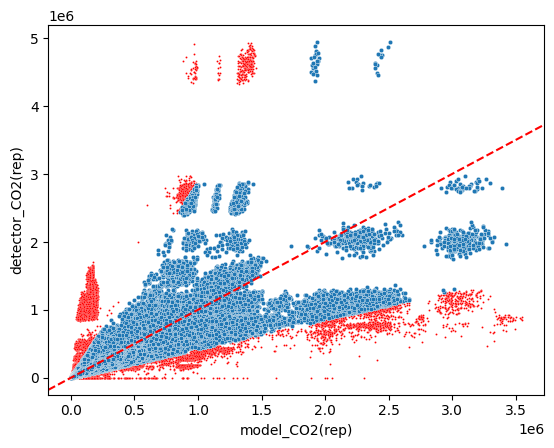

In [56]:
combined['rel_diff'] = (combined['model_CO2(rep)'] - combined['detector_CO2(rep)'])/combined['detector_CO2(rep)']
lb_test = np.percentile(combined['rel_diff'], 2.5)
ub_test = np.percentile(combined['rel_diff'], 97.5)

combined_sub = combined[(combined['rel_diff']>lb_test) & (combined['rel_diff']<ub_test)]
sns.scatterplot(data = combined, x='model_CO2(rep)', y='detector_CO2(rep)', s = 2, color = 'red')
sns.scatterplot(data = combined_sub, x='model_CO2(rep)', y='detector_CO2(rep)', s = 10)
plt.axline([0,0], [1,1], color = 'red', linestyle = '--')

<Axes: xlabel='model_CO2(rep)', ylabel='detector_CO2(rep)'>

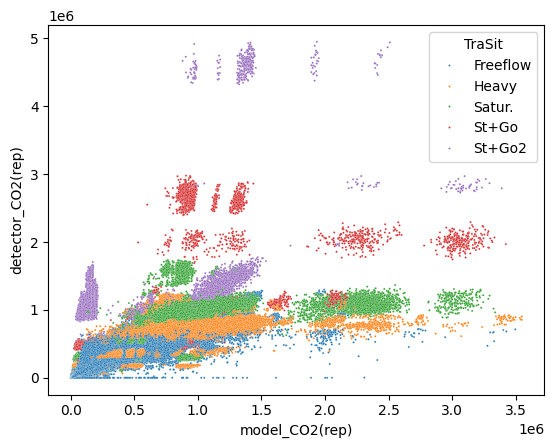

In [ ]:
sns.scatterplot(data = combined, x='model_CO2(rep)', y='detector_CO2(rep)', hue = 'TraSit', s = 2, color = 'red')